In [3]:
# ======================================
# 🔹 1. Imports
# ======================================
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModel
from PIL import Image, ImageChops

In [4]:
# ======================================
# 🔹 2. Setup
# ======================================
device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "facebook/dinov3-vits16-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(device).eval()

patch = model.config.patch_size
num_registers = model.config.num_register_tokens
layer_k = -1  # last layer features

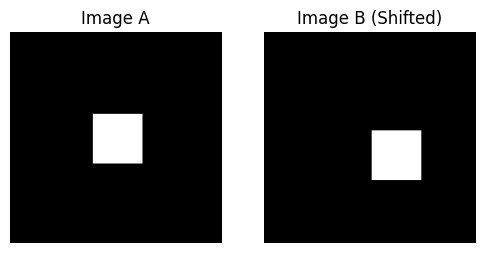

In [5]:
# ======================================
# 🔹 3. Create synthetic pair of images
# ======================================
# Base white square on black background
img_size = 256
base = Image.new("RGB", (img_size, img_size), "black")
for y in range(100, 160):
    for x in range(100, 160):
        base.putpixel((x, y), (255, 255, 255))

# Shifted version (simulate translation)
shifted = ImageChops.offset(base, 30, 20)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(base); plt.title("Image A"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(shifted); plt.title("Image B (Shifted)"); plt.axis("off")
plt.show()

In [6]:
# ======================================
# 🔹 4. DINO Feature Extraction
# ======================================
def extract_dino_patches(img):
    inputs = processor(images=img, return_tensors="pt", do_resize=False).to(device)
    out = model(**inputs)
    feats = out.hidden_states[layer_k]           # [1, 1+reg+N, C]
    feats = feats[:, 1 + num_registers:, :]      # remove CLS + register tokens
    _, _, H_px, W_px = inputs["pixel_values"].shape
    Hf = H_px // patch
    Wf = W_px // patch
    return feats, Hf, Wf

fA, HA, WA = extract_dino_patches(base)
fB, HB, WB = extract_dino_patches(shifted)
print(f"Patch grid: {HA}×{WA}, feature dim: {fA.shape[-1]}")

Patch grid: 16×16, feature dim: 384


In [7]:
# ======================================
# 🔹 5. Compute correspondence using DINO
# ======================================
fA = F.normalize(fA, dim=-1)
fB = F.normalize(fB, dim=-1)

sim = torch.matmul(fA, fB.transpose(1,2))[0]   # [NA, NB]
match_B = sim.argmax(dim=1).cpu().numpy()      # index of best match for each patch in A

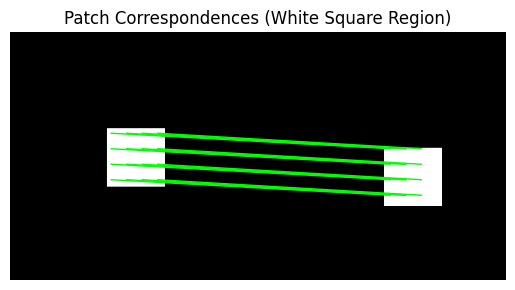

In [10]:
# ======================================
# 🔹 6. Focused Correspondence Visualization (square region)
# ======================================
def visualize_square_matches(imgA, imgB, Hf, Wf, match_B,
                             region=(100, 100, 160, 160),  # (x_min, y_min, x_max, y_max)
                             max_lines=100):
    """
    Draw correspondence lines only for patches inside a specific region.
    """
    imgA = np.array(imgA)
    imgB = np.array(imgB)
    h = max(imgA.shape[0], imgB.shape[0])
    imgA2 = np.array(Image.fromarray(imgA).resize((imgA.shape[1], h)))
    imgB2 = np.array(Image.fromarray(imgB).resize((imgB.shape[1], h)))
    canvas = np.concatenate([imgA2, imgB2], axis=1)

    stepA_x = imgA2.shape[1] / Wf
    stepA_y = h / Hf
    stepB_x = imgB2.shape[1] / Wf
    stepB_y = h / Hf

    # --- Select patches inside white square ---
    x_min, y_min, x_max, y_max = region
    centers = []
    for i in range(len(match_B)):
        yA = (i // Wf) * stepA_y + stepA_y / 2
        xA = (i % Wf) * stepA_x + stepA_x / 2
        if x_min <= xA <= x_max and y_min <= yA <= y_max:
            centers.append(i)

    # Subsample if too many
    if len(centers) > max_lines:
        centers = np.random.choice(centers, max_lines, replace=False)

    # --- Draw selected correspondences ---
    for i in centers:
        b_idx = match_B[i]
        Ay = (i // Wf) * stepA_y + stepA_y/2
        Ax = (i % Wf) * stepA_x + stepA_x/2
        By = (b_idx // Wf) * stepB_y + stepB_y/2
        Bx = (b_idx % Wf) * stepB_x + stepB_x/2 + imgA2.shape[1]
        plt.plot([Ax, Bx], [Ay, By], color="lime", linewidth=1)

    plt.imshow(canvas)
    plt.axis("off")
    plt.title("Patch Correspondences (White Square Region)")
    plt.show()

# 🔹 Run visualization
visualize_square_matches(base, shifted, HA, WA, match_B, region=(100, 100, 160, 160), max_lines=80)


In [11]:
# ======================================
# 🔹 7. Pixel-level patch correspondence loss
# ======================================
def pixel_patch_loss(pred_img, target_img, match_B, patch):
    pred = torch.tensor(np.array(pred_img)).permute(2,0,1).unsqueeze(0)/255.
    targ = torch.tensor(np.array(target_img)).permute(2,0,1).unsqueeze(0)/255.

    patches_A = pred.unfold(2, patch, patch).unfold(3, patch, patch)
    patches_B = targ.unfold(2, patch, patch).unfold(3, patch, patch)
    patches_A = patches_A.permute(0,2,3,1,4,5).reshape(-1,3,patch,patch)
    patches_B = patches_B.permute(0,2,3,1,4,5).reshape(-1,3,patch,patch)

    matched_B = patches_B[match_B]
    loss = F.l1_loss(patches_A, matched_B)
    return loss.item()

loss_val = pixel_patch_loss(base, shifted, match_B, patch)
print(f"Semantic-guided pixel L1 loss: {loss_val:.6f}")


Semantic-guided pixel L1 loss: 0.005371


In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Config and toy setup
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "facebook/dinov3-vits16-pretrain-lvd1689m"
patch_size = 16
search_r = 3  # can set None for global

processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(device).eval()

# two toy grayscale images
H, W = 256, 256
imgA = torch.rand(1, 1, H, W, device=device)
imgB = torch.roll(imgA, shifts=(10, 5), dims=(2, 3))  # shifted copy

# -------------------------------
# 2. DINO feature extraction
# -------------------------------
def extract_dino_patches(img):
    if img.shape[1] == 1:
        img = img.repeat(1, 3, 1, 1)
    pil_list = [Image.fromarray((x.permute(1, 2, 0).cpu().numpy() * 255).astype("uint8")) for x in img]
    inputs = processor(images=pil_list, do_resize=False, do_center_crop=False, return_tensors="pt").to(device)
    out = model(**inputs, output_hidden_states=True)
    feats = out.hidden_states[-1]  # last layer
    num_registers = model.config.num_register_tokens
    feats = feats[:, 1 + num_registers :, :]  # remove cls + register
    _, _, H_px, W_px = inputs["pixel_values"].shape
    Hf = H_px // patch_size
    Wf = W_px // patch_size
    Nf = Hf * Wf
    feats = feats[:, :Nf, :]
    return feats, Hf, Wf

fA, HA, WA = extract_dino_patches(imgA)
fB, HB, WB = extract_dino_patches(imgB)

print(f"DINO patch features: A={fA.shape}, B={fB.shape}")
print(f"Grid A=({HA},{WA}), B=({HB},{WB})")

# -------------------------------
# 3. Compute similarity
# -------------------------------
fA = F.normalize(fA, dim=-1)
fB = F.normalize(fB, dim=-1)
sim = torch.matmul(fA, fB.transpose(1, 2))  # [B, NA, NB]

# -------------------------------
# 4. Your correspondence function
# -------------------------------
def compute_correspondence(sim, WA, HA, WB, HB, r=None):
    sim = sim.squeeze(0)
    N_A, N_B = sim.shape
    device = sim.device

    if r is None:
        return sim.argmax(dim=1)

    coords_y_B = torch.arange(HB, device=device).repeat_interleave(WB)
    coords_x_B = torch.arange(WB, device=device).repeat(HB)
    match_B = torch.zeros(N_A, dtype=torch.long, device=device)

    for i in range(N_A):
        yA = i // WA
        xA = i % WA
        y_min, y_max = max(0, yA - r), min(HB - 1, yA + r)
        x_min, x_max = max(0, xA - r), min(WB - 1, xA + r)
        mask = (
            (coords_y_B >= y_min)
            & (coords_y_B <= y_max)
            & (coords_x_B >= x_min)
            & (coords_x_B <= x_max)
        )
        masked_scores = sim[i][mask]
        masked_idx = torch.nonzero(mask, as_tuple=False).squeeze(1)
        best_local = masked_idx[masked_scores.argmax()]
        match_B[i] = best_local
    return match_B

match_B = compute_correspondence(sim, WA, HA, WB, HB, r=search_r)
print(f"match_B shape: {match_B.shape}, min={match_B.min().item()}, max={match_B.max().item()}")

# -------------------------------
# 5. Extract pixel patches
# -------------------------------
B, C, H, W = imgA.shape
patches_A = imgA.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
patches_B = imgB.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
patches_A = patches_A.permute(0, 2, 3, 1, 4, 5).reshape(-1, C, patch_size, patch_size)
patches_B = patches_B.permute(0, 2, 3, 1, 4, 5).reshape(-1, C, patch_size, patch_size)

print(f"Pixel patches: A={patches_A.shape}, B={patches_B.shape}")

# sanity check
assert patches_B.shape[0] == fB.shape[1], f"Patch mismatch! pixel={patches_B.shape[0]} dino={fB.shape[1]}"
assert match_B.max() < patches_B.shape[0], f"Invalid match idx {match_B.max()} >= {patches_B.shape[0]}"

# -------------------------------
# 6. Compute loss and visualize
# -------------------------------
matched_B = patches_B[match_B]
loss = F.l1_loss(patches_A, matched_B)
print(f"✅ L1 correspondence pixel loss: {loss.item():.6f}")


DINO patch features: A=torch.Size([1, 256, 384]), B=torch.Size([1, 256, 384])
Grid A=(16,16), B=(16,16)
match_B shape: torch.Size([256]), min=1, max=255
Pixel patches: A=torch.Size([256, 1, 16, 16]), B=torch.Size([256, 1, 16, 16])
✅ L1 correspondence pixel loss: 0.333652
